In [2]:
# find out the max and min depth of the whole dataset

import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import torch
import glob

# Class for the calibration matrices for KITTI data
class Calibration:
    def __init__(self, calib_filepath):
        calibs = self.read_calib_file(calib_filepath)

        self.P = calibs['P2']
        self.P = np.reshape(self.P, [3,4])

        self.L2C = calibs['Tr_velo_to_cam']
        self.L2C = np.reshape(self.L2C, [3,4])

        self.R0 = calibs['R0_rect']
        self.R0 = np.reshape(self.R0,[3,3])

    @staticmethod
    def read_calib_file(filepath):
        data = {}
        with open(filepath, 'r') as f:
            for line in f.readlines():
                line = line.rstrip()
                if len(line)==0: continue
                key, value = line.split(':', 1)
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass
        return data
    
    # From LiDAR coordinate system to Camera Coordinate system
    def lidar2cam(self, pts_3d_lidar):
        n = pts_3d_lidar.shape[0]
        pts_3d_hom = np.hstack((pts_3d_lidar, np.ones((n,1))))
        pts_3d_cam_ref = np.dot(pts_3d_hom, np.transpose(self.L2C))
        pts_3d_cam_rec = np.transpose(np.dot(self.R0, np.transpose(pts_3d_cam_ref)))
        return pts_3d_cam_rec
    
    # From Camera Coordinate system to Image frame
    def rect2Img(self, rect_pts, img_width, img_height):
        n = rect_pts.shape[0]
        points_hom = np.hstack((rect_pts, np.ones((n,1))))
        points_2d = np.dot(points_hom, np.transpose(self.P)) # nx3
        points_2d[:,0] /= points_2d[:,2]
        points_2d[:,1] /= points_2d[:,2]
        
        mask = (points_2d[:,0] >= 0) & (points_2d[:,0] <= img_width) & (points_2d[:,1] >= 0) & (points_2d[:,1] <= img_height)
        mask = mask & (rect_pts[:,2] > 2)
        return points_2d[mask,0:2], mask

# From Github https://github.com/balcilar/DenseDepthMap
def dense_map(Pts, n, m, grid):
    ng = 2 * grid + 1
    
    mX = np.zeros((m,n)) + float("inf")
    mY = np.zeros((m,n)) + float("inf")
    mD = np.zeros((m,n))
    mX[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[0] - np.round(Pts[0])
    mY[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[1] - np.round(Pts[1])
    mD[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[2]
    
    KmX = np.zeros((ng, ng, m - ng, n - ng))
    KmY = np.zeros((ng, ng, m - ng, n - ng))
    KmD = np.zeros((ng, ng, m - ng, n - ng))
    
    for i in range(ng):
        for j in range(ng):
            KmX[i,j] = mX[i : (m - ng + i), j : (n - ng + j)] - grid - 1 +i
            KmY[i,j] = mY[i : (m - ng + i), j : (n - ng + j)] - grid - 1 +i
            KmD[i,j] = mD[i : (m - ng + i), j : (n - ng + j)]
    S = np.zeros_like(KmD[0,0])
    Y = np.zeros_like(KmD[0,0])
    
    for i in range(ng):
        for j in range(ng):
            s = 1/np.sqrt(KmX[i,j] * KmX[i,j] + KmY[i,j] * KmY[i,j])
            Y = Y + s * KmD[i,j]
            S = S + s
    
    S[S == 0] = 1
    out = np.zeros((m,n))
    out[grid + 1 : -grid, grid + 1 : -grid] = Y/S
    return out


def dense_map_new(lidarOnImage, n, m, grid):
    # remove out of image size indexes
    mask = (lidarOnImage[:, :2] >= 1).all(axis=1)
    Pts = lidarOnImage[mask].T

    ng = 2 * grid + 1

    mX = np.zeros((m,n)) + float("inf") # inf-matrix
    mY = np.zeros((m,n)) + float("inf") # inf-matrix
    mD = np.zeros((m,n))
    mX[np.int32(np.round(Pts[1])-1),np.int32(np.round(Pts[0])-1)] = Pts[0] - np.round(Pts[0])
    mY[np.int32(np.round(Pts[1])-1),np.int32(np.round(Pts[0])-1)] = Pts[1] - np.round(Pts[1])
    mD[np.int32(np.round(Pts[1])-1),np.int32(np.round(Pts[0])-1)] = Pts[2]

    KmX = np.zeros((ng, ng, m - 2*grid, n - 2*grid))
    KmY = np.zeros((ng, ng, m - 2*grid, n - 2*grid))
    KmD = np.zeros((ng, ng, m - 2*grid, n - 2*grid))

    for i in range(ng):
        for j in range(ng):
            KmX[i,j] = mX[i : (m - 2*grid + i), j : (n - 2*grid + j)] - grid + j
            KmY[i,j] = mY[i : (m - 2*grid + i), j : (n - 2*grid + j)] - grid + i
            KmD[i,j] = mD[i : (m - 2*grid + i), j : (n - 2*grid + j)]

    S = np.zeros_like(KmD[0,0])
    Y = np.zeros_like(KmD[0,0])

    for i in range(ng):
        for j in range(ng):
            s = 1/np.sqrt(KmX[i,j] * KmX[i,j] + KmY[i,j] * KmY[i,j])
            Y = Y + s * KmD[i,j]
            S = S + s

    S[S == 0] = 1
    out = np.zeros((m,n))
    out[grid : -grid, grid  : -grid] = Y/S
    return out

if __name__ == "__main__":
    root = "../../public/dataset_expensive_storage/KITTI/training/"
    image_dir = os.path.join(root, "image_2")
    velodyne_dir = os.path.join(root, "velodyne")
    calib_dir = os.path.join(root, "calib")

    max_list = []
    min_list = []
    # Data id
    for i in range(7200):
        cur_id = i
        if i%10 ==0:
            print(f'{i}/7200')
        # Loading the image
        img = cv2.imread(os.path.join(image_dir, "%06d.png" % cur_id))
        # Loading the LiDAR data
        lidar = np.fromfile(os.path.join(velodyne_dir, "%06d.bin" % cur_id), dtype=np.float32).reshape(-1, 4)
        # Loading Calibration
        calib = Calibration(os.path.join(calib_dir, "%06d.txt" % cur_id))
        # From LiDAR coordinate system to Camera Coordinate system
        lidar_rect = calib.lidar2cam(lidar[:,0:3])
        # From Camera Coordinate system to Image frame
        lidarOnImage, mask = calib.rect2Img(lidar_rect, img.shape[1], img.shape[0])
        # Concatenate LiDAR position with the intesity (3), with (2) we would have the depth
        lidarOnImage = np.concatenate((lidarOnImage, lidar_rect[mask,2].reshape(-1,1)), 1)

        # print(lidarOnImage.shape) --> (20285, 3)
        
#!!!!!!!!!!!!!!!!!! use 'lidarOnImage', not!!! 'lidarOnImage.T'
        out = dense_map_new(lidarOnImage, img.shape[1], img.shape[0], 5)
        out_tensor = torch.unsqueeze(torch.from_numpy(out), dim=0)
        out_tensor = out_tensor[0,150:350, 600:800].unsqueeze(0)
        max_list.append(torch.max(out_tensor))

        # name = "%06d.pth" % cur_id
        # resized_tensor = F.interpolate(out_tensor, size=(100, 400), mode='bilinear', align_corners=False)
        # torch.save(resized_tensor, f'lidar_tensor/{name}')

    print(max(max_list))

0/7200
10/7200
20/7200
30/7200
40/7200
50/7200
60/7200
70/7200
80/7200
90/7200
100/7200
110/7200
120/7200
130/7200
140/7200
150/7200
160/7200
170/7200
180/7200
190/7200
200/7200
210/7200
220/7200
230/7200
240/7200
250/7200
260/7200
270/7200
280/7200
290/7200
300/7200
310/7200
320/7200
330/7200
340/7200
350/7200
360/7200
370/7200
380/7200
390/7200
400/7200
410/7200
420/7200
430/7200
440/7200
450/7200
460/7200
470/7200
480/7200
490/7200
500/7200
510/7200
520/7200
530/7200
540/7200
550/7200
560/7200
570/7200
580/7200
590/7200
600/7200
610/7200
620/7200
630/7200
640/7200
650/7200
660/7200
670/7200
680/7200
690/7200
700/7200
710/7200
720/7200
730/7200
740/7200
750/7200
760/7200
770/7200
780/7200
790/7200
800/7200
810/7200
820/7200
830/7200
840/7200
850/7200
860/7200
870/7200
880/7200
890/7200
900/7200
910/7200
920/7200
930/7200
940/7200
950/7200
960/7200
970/7200
980/7200
990/7200
1000/7200
1010/7200
1020/7200
1030/7200
1040/7200
1050/7200
1060/7200
1070/7200
1080/7200
1090/7200
1100/7200
1

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import torch
import glob
import torch.nn.functional as F
from torchvision import transforms


# Class for the calibration matrices for KITTI data
class Calibration:
    def __init__(self, calib_filepath):
        calibs = self.read_calib_file(calib_filepath)

        self.P = calibs['P2']
        self.P = np.reshape(self.P, [3,4])

        self.L2C = calibs['Tr_velo_to_cam']
        self.L2C = np.reshape(self.L2C, [3,4])

        self.R0 = calibs['R0_rect']
        self.R0 = np.reshape(self.R0,[3,3])

    @staticmethod
    def read_calib_file(filepath):
        data = {}
        with open(filepath, 'r') as f:
            for line in f.readlines():
                line = line.rstrip()
                if len(line)==0: continue
                key, value = line.split(':', 1)
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass
        return data
    
    # From LiDAR coordinate system to Camera Coordinate system
    def lidar2cam(self, pts_3d_lidar):
        n = pts_3d_lidar.shape[0]
        pts_3d_hom = np.hstack((pts_3d_lidar, np.ones((n,1))))
        pts_3d_cam_ref = np.dot(pts_3d_hom, np.transpose(self.L2C))
        pts_3d_cam_rec = np.transpose(np.dot(self.R0, np.transpose(pts_3d_cam_ref)))
        return pts_3d_cam_rec
    
    # From Camera Coordinate system to Image frame
    def rect2Img(self, rect_pts, img_width, img_height):
        n = rect_pts.shape[0]
        points_hom = np.hstack((rect_pts, np.ones((n,1))))
        points_2d = np.dot(points_hom, np.transpose(self.P)) # nx3
        points_2d[:,0] /= points_2d[:,2]
        points_2d[:,1] /= points_2d[:,2]
        
        mask = (points_2d[:,0] >= 0) & (points_2d[:,0] <= img_width) & (points_2d[:,1] >= 0) & (points_2d[:,1] <= img_height)
        mask = mask & (rect_pts[:,2] > 2)
        return points_2d[mask,0:2], mask

# From Github https://github.com/balcilar/DenseDepthMap
def dense_map(Pts, n, m, grid): # something wrong!  
    # Actually there are a lot of errors in python script, because he forgets that the array begins in matlab with 1 but in python 0, which means array[0](in python)=array[1](in matlab). And if a range is (a:b), in matlab 'b' will be included and in python 'b' is excluded. 
    ng = 2 * grid + 1
    
    mX = np.zeros((m,n)) + float("inf")
    mY = np.zeros((m,n)) + float("inf")
    mD = np.zeros((m,n))
    mX[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[0] - np.round(Pts[0])
    mY[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[1] - np.round(Pts[1])
    mD[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[2]
    
    KmX = np.zeros((ng, ng, m - ng, n - ng))
    KmY = np.zeros((ng, ng, m - ng, n - ng))
    KmD = np.zeros((ng, ng, m - ng, n - ng))
    
    for i in range(ng):
        for j in range(ng):
            KmX[i,j] = mX[i : (m - ng + i), j : (n - ng + j)] - grid - 1 +i
            KmY[i,j] = mY[i : (m - ng + i), j : (n - ng + j)] - grid - 1 +i
            KmD[i,j] = mD[i : (m - ng + i), j : (n - ng + j)]
    S = np.zeros_like(KmD[0,0])
    Y = np.zeros_like(KmD[0,0])
    
    for i in range(ng):
        for j in range(ng):
            s = 1/np.sqrt(KmX[i,j] * KmX[i,j] + KmY[i,j] * KmY[i,j])
            Y = Y + s * KmD[i,j]
            S = S + s
    
    S[S == 0] = 1
    out = np.zeros((m,n))
    out[grid + 1 : -grid, grid + 1 : -grid] = Y/S
    return out

import numpy as np

# From Github https://github.com/BerensRWU/DenseMap#readme
# From Github https://github.com/balcilar/DenseDepthMap

def dense_map_new(lidarOnImage, n, m, grid):
    # remove out of image size indexes
    mask = (lidarOnImage[:, :2] >= 1).all(axis=1)
    Pts = lidarOnImage[mask].T

    ng = 2 * grid + 1

    mX = np.zeros((m,n)) + float("inf") # inf-matrix
    mY = np.zeros((m,n)) + float("inf") # inf-matrix
    mD = np.zeros((m,n))
    mX[np.int32(np.round(Pts[1])-1),np.int32(np.round(Pts[0])-1)] = Pts[0] - np.round(Pts[0])
    mY[np.int32(np.round(Pts[1])-1),np.int32(np.round(Pts[0])-1)] = Pts[1] - np.round(Pts[1])
    mD[np.int32(np.round(Pts[1])-1),np.int32(np.round(Pts[0])-1)] = Pts[2]

    KmX = np.zeros((ng, ng, m - 2*grid, n - 2*grid))
    KmY = np.zeros((ng, ng, m - 2*grid, n - 2*grid))
    KmD = np.zeros((ng, ng, m - 2*grid, n - 2*grid))

    for i in range(ng):
        for j in range(ng):
            KmX[i,j] = mX[i : (m - 2*grid + i), j : (n - 2*grid + j)] - grid + j
            KmY[i,j] = mY[i : (m - 2*grid + i), j : (n - 2*grid + j)] - grid + i
            KmD[i,j] = mD[i : (m - 2*grid + i), j : (n - 2*grid + j)]

    S = np.zeros_like(KmD[0,0])
    Y = np.zeros_like(KmD[0,0])

    for i in range(ng):
        for j in range(ng):
            s = 1/np.sqrt(KmX[i,j] * KmX[i,j] + KmY[i,j] * KmY[i,j])
            Y = Y + s * KmD[i,j]
            S = S + s

    S[S == 0] = 1
    out = np.zeros((m,n))
    out[grid : -grid, grid  : -grid] = Y/S
    return out


if __name__ == "__main__":
    root = "../../public/dataset_expensive_storage/KITTI/training/"
    image_dir = os.path.join(root, "image_2")
    velodyne_dir = os.path.join(root, "velodyne")
    calib_dir = os.path.join(root, "calib")

    tensors_max = torch.tensor(80, dtype=torch.float32)
    tensors_min = torch.tensor(0, dtype=torch.float32)
    
    depths_max_list = []
    
    # Data id
    for i in range(7200):
        if i > 4730:
            cur_id = i
            if i%10 ==0:
                print(f'{i}/7200')
            # Loading the image
            img = cv2.imread(os.path.join(image_dir, "%06d.png" % cur_id))
            # Loading the LiDAR data
            lidar = np.fromfile(os.path.join(velodyne_dir, "%06d.bin" % cur_id), dtype=np.float32).reshape(-1, 4)
            # Loading Calibration
            calib = Calibration(os.path.join(calib_dir, "%06d.txt" % cur_id))
            # From LiDAR coordinate system to Camera Coordinate system
            lidar_rect = calib.lidar2cam(lidar[:,0:3])
            # From Camera Coordinate system to Image frame
            lidarOnImage, mask = calib.rect2Img(lidar_rect, img.shape[1], img.shape[0])
            # Concatenate LiDAR position with the intesity (3), with (2) we would have the depth
            lidarOnImage = np.concatenate((lidarOnImage, lidar_rect[mask,2].reshape(-1,1)), 1)

            # print(lidarOnImage.shape) --> (20285, 3)

    #         # 1. create depth map
    #         points = lidarOnImage.T
    #         # print(points.shape)
    #         u, v, depths = points

    #         convert_tensor = transforms.ToTensor()
    #         points = convert_tensor(points)
    #         # print(points.shape)

    #         depths = torch.tensor(depths)


    #         IMG_W = img.shape[1]
    #         IMG_H = img.shape[0]
    #         # print(IMG_H,IMG_W) --> 370 1224

    #         tensor_save = torch.zeros((1,IMG_H,IMG_W))

    #         dim0, dim1, dim2 = points.shape
    #         for i in range(dim2):
    #             y = points[0,0,i]
    #             y = y.long()
    #             x = points[0,1,i]
    #             x = x.long()
    #             z = depths[i]
    #             z = z.long()
    #             tensor_save[0,x,y] = z
    #         # print(tensor_save.shape)
    #         name = "%06d.pth" % cur_id
    #         tensor_save = tensor_save[0,150:350, 600:800].unsqueeze(0)
    #         # depth_max = torch.max(tensor_save)
    #         # depths_max_list.append(depth_max)

    #         tensor_save = (tensor_save-tensors_min)/(tensors_max-tensors_min)
    #         tensor_save = tensor_save.float()
    #         torch.save(tensor_save, f'lidar_tesor_200_sparse/{name}')



        # print(max(depths_max_list))

    #     print(tensor_save.shape)        



            # 2. interpolation --> create dense depth map
            out = dense_map_new(lidarOnImage, img.shape[1], img.shape[0], 6)
            out_tensor = torch.unsqueeze(torch.from_numpy(out), dim=0)
            # print(out_tensor.max())
            out_tensor = out_tensor[0,150:350, 600:800].unsqueeze(0)

            name = "%06d.pth" % cur_id

            # resized_tensor = F.interpolate(out_tensor.unsqueeze(0), size=(100, 400), mode='bilinear', align_corners=False)
            # resized_tensor = torch.squeeze(resized_tensor).unsqueeze(0)
            # print(resized_tensor.max())

            out_tensor = (out_tensor-tensors_min)/(tensors_max-tensors_min)
            out_tensor = out_tensor.float()
            # print(resized_tensor.shape)
            torch.save(out_tensor, f'lidar_tesor_200_dense/{name}')



4740/7200
4750/7200
4760/7200
4770/7200
4780/7200
4790/7200
4800/7200
4810/7200
4820/7200
4830/7200
4840/7200
4850/7200
4860/7200
4870/7200
4880/7200
4890/7200
4900/7200
4910/7200
4920/7200
4930/7200
4940/7200
4950/7200
4960/7200
4970/7200
4980/7200
4990/7200
5000/7200
5010/7200
5020/7200
5030/7200
5040/7200
5050/7200
5060/7200
5070/7200
5080/7200
5090/7200
5100/7200
5110/7200
5120/7200
5130/7200
5140/7200
5150/7200
5160/7200
5170/7200
5180/7200
5190/7200
5200/7200
5210/7200
5220/7200
5230/7200
5240/7200
5250/7200
5260/7200
5270/7200
5280/7200
5290/7200
5300/7200
5310/7200
5320/7200
5330/7200
5340/7200
5350/7200
5360/7200
5370/7200
5380/7200
5390/7200
5400/7200
5410/7200
5420/7200
5430/7200
5440/7200
5450/7200
5460/7200
5470/7200
5480/7200
5490/7200
5500/7200
5510/7200
5520/7200
5530/7200
5540/7200
5550/7200
5560/7200
5570/7200
5580/7200
5590/7200
5600/7200
5610/7200
5620/7200
5630/7200
5640/7200
5650/7200
5660/7200
5670/7200
5680/7200
5690/7200
5700/7200
5710/7200
5720/7200
5730/7200


torch.Size([1, 100, 400])


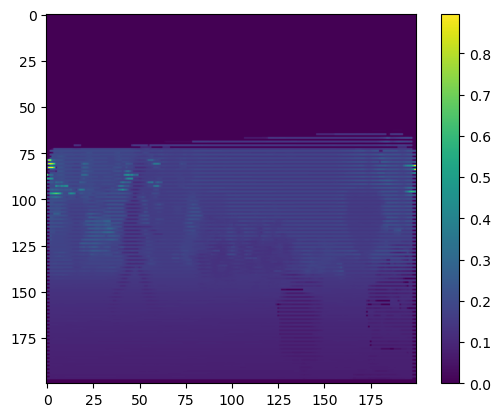

In [5]:
# test the ldiar tensor
import matplotlib.pyplot as plt
import cv2
import torch

# test = torch.load('lidar_tesor_200_dense/000000.pth')
test = torch.load('../KITTI TEST/lidar_tensor/000000.pth')
print(test.shape)
plt.imshow(test.view(200,200))
plt.colorbar()

370 1224
Minimum value: 4.219317571710777
Maximum value: 72.72995055815288
torch.Size([1, 3, 20285])
torch.Size([1, 200, 200])


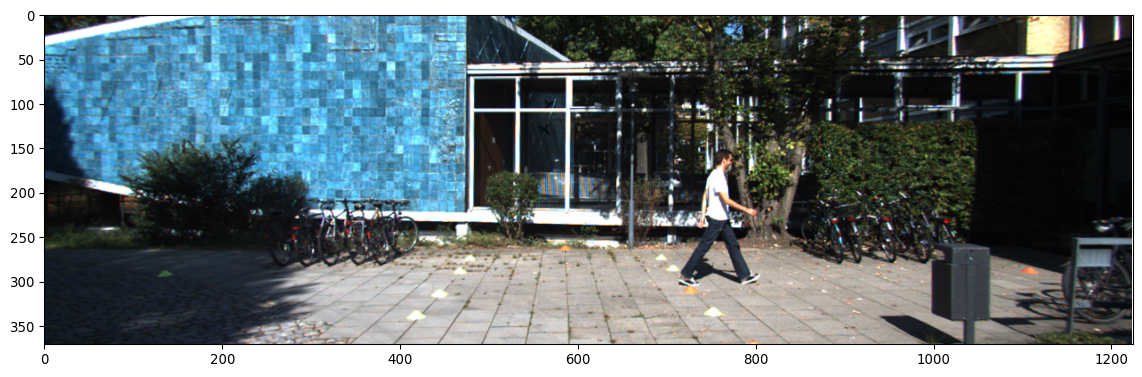

In [13]:
# depth map

import torch
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from torchvision import transforms


sn = 0
name = '%06d' % sn
img = f'../../public/dataset_expensive_storage/KITTI/training/image_2/{name}.png'
binary = f'../../public/dataset_expensive_storage/KITTI/training/velodyne/{name}.bin'
with open(f'../../public/dataset_expensive_storage/KITTI/training/calib/{name}.txt', 'r') as f:
    calib = f.readlines()

P2 = np.array([float(x) for x in calib[2].strip('\n').split(' ')[1:]]).reshape(3, 4)
R0_rect = np.array([float(x) for x in calib[4].strip('\n').split(' ')[1:]]).reshape(3, 3)
R0_rect = np.insert(R0_rect, 3, values=[0, 0, 0], axis=0)
R0_rect = np.insert(R0_rect, 3, values=[0, 0, 0, 1], axis=1)
Tr_velo_to_cam = np.array([float(x) for x in calib[5].strip('\n').split(' ')[1:]]).reshape(3, 4)
Tr_velo_to_cam = np.insert(Tr_velo_to_cam, 3, values=[0, 0, 0, 1], axis=0)

scan = np.fromfile(binary, dtype=np.float32).reshape((-1, 4))
points = scan[:, 0:3]
velo = np.insert(points, 3, 1, axis=1).T
velo = np.delete(velo, np.where(velo[0, :] < 0), axis=1)
cam = P2.dot(R0_rect.dot(Tr_velo_to_cam.dot(velo)))
cam = np.delete(cam, np.where(cam[2, :] < 0), axis=1)
cam[:2] /= cam[2, :] # (3, 60675)

plt.figure(figsize=(12, 5), dpi=96, tight_layout=True)
png = mpimg.imread(img)
IMG_H, IMG_W, _ = png.shape
plt.axis([0, IMG_W, IMG_H, 0])
# plt.imshow(png)

print(IMG_H,IMG_W)

u, v, depths = cam

u_out = np.logical_or(u < 0, u > IMG_W)
v_out = np.logical_or(v < 0, v > IMG_H)
outlier = np.logical_or(u_out, v_out)
cam = np.delete(cam, np.where(outlier), axis=1)

first_row = cam[2, :]
min_value = np.min(first_row)
max_value = np.max(first_row)

print("Minimum value:", min_value)
print("Maximum value:", max_value)

convert_tensor = transforms.ToTensor()
points = convert_tensor(cam)
print(points.shape)

depths = torch.tensor(depths)

tensor_save = torch.zeros((1,IMG_H,IMG_W))

dim0, dim1, dim2 = points.shape
for i in range(dim2):
    y = points[0,0,i]
    y = y.long()
    x = points[0,1,i]
    x = x.long()
    z = depths[i]
    z = z.long()
    tensor_save[0,x,y] = z

tensor_save = tensor_save[0,150:350, 600:800].unsqueeze(0)

torch.save(tensor_save, f'{name}.pth')

print(tensor_save.shape)

In [2]:
# test the ldiar tensor
test = torch.load('000000.pth')
test = test/80
print(test.shape)
plt.imshow(test.view(200, 200))
plt.colorbar()

SyntaxError: invalid syntax (1681951448.py, line 4)

In [ ]:
# !!!!!! not much difference between the two methodes.